<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/reach_croptype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Purpose:** Identify crop percentages within each Reach of Mason Drainage.


Link to crop identification --> https://github.com/LEAF-BoiseState/janus/blob/master/janus/tests/data/CDL2GCAM_categories.csv

In [2]:
# ------------------ #
#  Import Libraries  #
# ------------------ #
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
! pip install rasterio
import rasterio
import rasterio.features
from rasterio.mask import mask
from rasterio import mask
from rasterio.crs import CRS
import glob
import json
import os
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from collections import Counter
from PIL import Image

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mask CDL Data to Each Reach

In [12]:
# ---------------------------- #
#   Mask to Reach Shapefile    #
# ---------------------------- #

reaches = gpd.read_file('/content/drive/MyDrive/Data/Mason Water Budget/data_input/reach_shapefile/Reaches_Final_1209/Reach_Final.shp')
years = list(range(2014, 2024))
cdl_files = [f'/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/mason_cdl/mason{year}.tif' for year in years]

# Output directory
output_dir = '/content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Open CDL files and reproject shapefile to match raster CRS
data = [rasterio.open(file) for file in cdl_files]
reaches = reaches.to_crs(data[0].crs)  # Reproject reach shapefile to match raster CRS

# Loop through each reach and each year of CDL data
for i, row in reaches.iterrows():
    feature_name = row['Reach']  # Reach name
    geometry = row['geometry']  # Reach geometry
    coords = [json.loads(gpd.GeoSeries(geometry).to_json())['features'][0]['geometry']]  # Geometry in JSON format

    for dataset in data:
        # Extract the last 4 digits before the ".tif" extension to get the year
        year_out = dataset.name[-8:-4]  # This extracts "2014" from "mason2014.tif"

        # Perform the masking operation
        out_img, out_transform = rasterio.mask.mask(dataset=dataset, shapes=coords, crop=True, nodata=0)  # Use 'rio_mask'
        out_meta = dataset.meta.copy()  # Copy metadata
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform
        })

        # Construct output filename using reach name and year in the format '{name}_{year}.tif'
        out_filename = os.path.join(output_dir, f'{feature_name}_{year_out}.tif')

        # Save the masked raster
        with rasterio.open(out_filename, 'w', **out_meta) as out_tiff:
            out_tiff.write(np.squeeze(out_img, 0), 1)

        print(f'Cropped raster for {feature_name} in {year_out} saved to {out_filename}')


Cropped raster for Noble Drain in 2014 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2014.tif
Cropped raster for Noble Drain in 2015 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2015.tif
Cropped raster for Noble Drain in 2016 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2016.tif
Cropped raster for Noble Drain in 2017 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2017.tif
Cropped raster for Noble Drain in 2018 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2018.tif
Cropped raster for Noble Drain in 2019 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2019.tif
Cropped raster for Noble Drain in 2020 saved to /content/drive/MyDrive/Data/Mason/data_input/land_cover/masked/Noble Drain_2020.tif
Cropped raster for Noble Drain in 2021 saved to /content/drive/MyDrive/Data/

## Choose Crop Type Delineation

In [20]:
## ---------------------- ##
#    Classify Crop Types
## ---------------------- ##

# cdl identified crop type

crop_types = {
    1:'Corn',
    2:'Cotton',
    3:'Rice',
    4:'Sorghum',
    5:'Soybeans',
    6:'Sunflower',
    10:'Peanuts',
    11:'Tobacco',
    12:'Sweet Corn',
    13:'Corn',
    14:'Mint',
    21:'Barley',
    22:'Durum Wheat',
    23:'Spring Wheat',
    24:'Winter Wheat',
    25:'Other Small Grains',
    26:'Dbl Crop WinWht/Soybeans',
    27:'Rye',
    28:'Oats',
    29:'Millet',
    30:'Speltz',
    31:'Canola',
    32:'Flaxseed',
    33:'Safflower',
    34:'Brassica napus',
    35:'Mustard',
    36:'Alfalfa',
    37:'Other Hay/Non Alfalfa',
    38:'Camelina',
    39:'Buckwheat',
    41:'Sugarbeets',
    42:'Dry Beans',
    43:'Potatoes',
    44:'Other Crops',
    45:'Sugarcane',
    46:'Sweet Potatoes',
    47:'Misc Vegs & Fruits',
    48:'Watermelons',
    49:'Onions',
    50:'Cucumbers',
    51:'Chick Peas',
    52:'Lentils',
    53:'Peas',
    54:'Tomatoes',
    55:'Caneberries',
    56:'Hops',
    57:'Herbs',
    58:'Clover/Wildflowers',
    59:'Sod/Grass Seed',
    60:'Switchgrass',
    61:'Fallow/Idle Cropland',
    62:'Pasture/Grass',
    63:'Forest',
    64:'Shrubland',
    65:'Barren',
    66:'Cherries',
    67:'Peaches',
    68:'Apples',
    69:'Grapes',
    70:'Christmas Trees',
    71:'Other Tree Crops',
    72:'Citrus',
    74:'Pecans',
    75:'Almonds',
    76:'Walnuts',
    77:'Pears',
    81:'Clouds/No Data',
    82:'Developed',
    83:'Water',
    87:'Wetlands',
    88:'Nonag/Undefined',
    92:'Aquaculture',
    111:'Open Water',
    112:'Perennial Ice/Snow',
    121:'Developed/Open Space',
    122:'Developed', #Low Intensity
    123:'Developed', #Med Intensity
    124:'Developed', #High Intensity
    131:'Barren',
    141:'Deciduous Forest',
    142:'Evergreen Forest',
    143:'Mixed Forest',
    152:'Shrubland',
    176:'Grassland/Pasture',
    190:'Woody Wetlands',
    195:'Herbaceous Wetlands',
    204:'Pistachios',
    205:'Wheat',
    206:'Carrots',
    207:'Asparagus',
    208:'Garlic',
    209:'Cantaloupes',
    210:'Prunes',
    211:'Olives',
    212:'Oranges',
    213:'Honeydew Melons',
    214:'Broccoli',
    215:'Avocados',
    216:'Peppers',
    217:'Pomegranates',
    218:'Nectarines',
    219:'Greens',
    220:'Plums',
    221:'Strawberries',
    222:'Squash',
    223:'Apricots',
    224:'Vetch',
    225:'Dbl Crop WinWht/Corn',
    226:'Dbl Crop Oats/Corn',
    227:'Lettuce',
    228:'Dbl Crop Triticale/Corn',
    229:'Pumpkins',
    230:'Dbl Crop', #Lettuce/Durum Wht
    231:'Dbl Crop', #Lettuce/Cantaloupe
    232:'Dbl Crop', #Lettuce/Cotton
    233:'Dbl Crop', #Lettuce/Barley
    234:'Dbl Crop', #Durum Wht/Sorghum
    235:'Dbl Crop', #Barley/Sorghum
    236:'Dbl Crop', #WinWht/Sorghum
    237:'Dbl Crop', #Barley/Corn
    238:'Dbl Crop', #WinWht/Cotton
    239:'Dbl Crop', #Soybeans/Cotton
    240:'Dbl Crop', #Soybeans/Oats
    241:'Dbl Crop', #Corn/Soybeans
    242:'Blueberries',
    243:'Cabbage',
    244:'Cauliflower',
    245:'Celery',
    246:'Radishes',
    247:'Turnips',
    248:'Eggplants',
    249:'Gourds',
    250:'Cranberries',
    254:'Dbl Crop Barley/Soybeans'}

In [35]:
## ---------------------- ##
#    Classify Crop Types
## ---------------------- ##

# SIMPLIFIED

crop_types = {
    1:'Corn',
    2:'Cotton',
    3:'Rice',
    4:'Sorghum',
    5:'Soybeans',
    6:'Sunflower',
    10:'Peanuts',
    11:'Tobacco',
    12:'Corn',
    13:'Corn',
    14:'Mint',
    21:'Wheat',
    22:'Wheat',
    23:'Wheat',
    24:'Wheat',
    25:'Other Small Grains',
    26:'Double Crop',
    27:'Wheat',
    28:'Wheat',
    29:'Wheat',
    30:'Speltz',
    31:'Canola',
    32:'Flaxseed',
    33:'Safflower',
    34:'Brassica napus',
    35:'Mustard',
    36:'Wheat',
    37:'Wheat',
    38:'Camelina',
    39:'Wheat',
    41:'Sugarbeets',
    46:'Sweet Potatoes', #change to veggies/fruit?
    47:'Vegetables/Fruit',
    48:'Other',
    49:'Onions',
    50:'Other',
    51:'Dry Beans',
    52:'Dry Beans',
    53:'Peas',
    54:'Vegetables/Fruit',
    55:'Vegetables/Fruit',
    56:'Hops',
    57:'Herbs',
    58:'Clover/Wildflowers',
    59:'Pasture',
    60:'Switchgrass',
    61:'Fallow/Idle Cropland',
    62:'Pasture',
    63:'Forest',
    64:'Shrubland',
    65:'Barren',
    66:'Cherries',
    67:'Peaches',
    68:'Vegetables/Fruit',
    69:'Vegetables/Fruit',
    70:'Christmas Trees',
    71:'Other Tree Crops',
    72:'Vegetables/Fruit',
    74:'Pecans',
    75:'Almonds',
    76:'Walnuts',
    77:'Vegetables/Fruit',
    81:'Clouds/No Data',
    82:'Developed',
    83:'Water',
    87:'Wetlands',
    88:'Nonag/Undefined',
    92:'Aquaculture',
    111:'Open Water',
    112:'Perennial Ice/Snow',
    121:'Developed/Open Space',
    122:'Developed', #Low Intensity
    123:'Developed', #Med Intensity
    124:'Developed', #High Intensity
    131:'Barren',
    141:'Deciduous Forest',
    142:'Evergreen Forest',
    143:'Mixed Forest',
    152:'Shrubland',
    176:'Pasture',
    190:'Woody Wetlands',
    195:'Shrubland',
    204:'Pistachios',
    205:'Wheat',
    206:'Vegetables/Fruit',
    207:'Vegetables/Fruit',
    208:'Vegetables/Fruit',
    209:'Vegetables/Fruit',
    210:'Vegetables/Fruit',
    211:'Olives',
    212:'Vegetables/Fruit',
    213:'Honeydew Melons',
    214:'Vegetables/Fruit',
    215:'Avocados',
    216:'Vegetables/Fruit',
    217:'Vegetables/Fruit',
    218:'Vegetables/Fruit',
    219:'Greens',
    220:'Vegetables/Fruit',
    221:'Vegetables/Fruit',
    222:'Vegetables/Fruit',
    223:'Vegetables/Fruit',
    224:'Vetch',
    225:'Double Crop',
    226:'Double Crop',
    227:'Lettuce',
    228:'Double Crop',
    229:'Pumpkins',
    230:'Double Crop', #Lettuce/Durum Wht
    231:'Double Crop', #Lettuce/Cantaloupe
    232:'Double Crop', #Lettuce/Cotton
    233:'Double Crop', #Lettuce/Barley
    234:'Double Crop', #Durum Wht/Sorghum
    235:'Double Crop', #Barley/Sorghum
    236:'Double Crop', #WinWht/Sorghum
    237:'Double Crop', #Barley/Corn
    238:'Double Crop', #WinWht/Cotton
    239:'Double Crop', #Soybeans/Cotton
    240:'Double Crop', #Soybeans/Oats
    241:'Double Crop', #Corn/Soybeans
    242:'Blueberries',
    243:'Vegetables/Fruit',
    244:'Vegetables/Fruit',
    245:'Vegetables/Fruit',
    246:'Vegetables/Fruit',
    247:'Vegetables/Fruit',
    248:'Vegetables/Fruit',
    249:'Vegetables/Fruit',
    250:'Vegetables/Fruit',
    254:'Double Crop'}


In [36]:
# ------------------- #
# CDL from pixel to acres
# ------------------- #

# Path to the directory where the masked CDL files are saved
cdl_data_files = glob.glob('/content/drive/MyDrive/Data/Mason Water Budget/data_input/land_cover/masked_2023/*.tif')

# Directory to save the output CSV file
output_file = '/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/2023_cdl_reach.csv'  # Change date if needed

# Initialize a list to collect all reach data
all_reach_data = []

# Process each .tif file
for file in cdl_data_files:
    reach_name = os.path.splitext(os.path.basename(file))[0]  # Extract reach name from filename
    print(f"\nProcessing file: {reach_name}")  # Debug: print file being processed

    # Open the .tif file and read crop type codes
    with rasterio.open(file) as src:
        cdl_array = src.read(1)  # Read the first band (assuming it's a single-band file)
        pixel_area = abs(src.transform[0] * src.transform[4])  # Calculate the area of a pixel (e.g., 30m x 30m)
        print(f"Unique crop codes in array for {reach_name}: {set(cdl_array.flatten())}")  # Debug: check crop codes
        print(f"Pixel area (square meters): {pixel_area}")  # Debug: print pixel area

    # Classify the data by crop type
    classified_data = {crop_type: (cdl_array == code) for code, crop_type in crop_types.items()}
    print(f"Classified data for {reach_name}: { {k: v.sum() for k, v in classified_data.items()} }")  # Debug: show classified data counts

    # Calculate area for each crop type and collect data
    for crop_type, mask in classified_data.items():
        area_pixels = mask.sum()  # Count pixels for each crop type
        area_acres = area_pixels * pixel_area * 0.000247105  # Convert square meters to acres
        # Remove the conditional filter for debugging purposes
        all_reach_data.append({
            "Reach": reach_name,
            "Acres": area_acres,
            "Crop": crop_type
        })

# Create a DataFrame with all reach data
df = pd.DataFrame(all_reach_data)
print(df)  # Debug: print entire DataFrame to check content

# Save the DataFrame to a single CSV file
df.to_csv(output_file, index=False)
print(f"All reach data saved to {output_file}")


Processing file: Noble Drain
Unique crop codes in array for Noble Drain: {0, 1, 131, 4, 6, 12, 14, 21, 23, 152, 24, 27, 28, 36, 37, 41, 42, 43, 44, 47, 176, 49, 53, 56, 59, 61, 66, 67, 195, 69, 205, 206, 221, 228, 237, 111, 247, 121, 122, 123, 124}
Pixel area (square meters): 900.0
Classified data for Noble Drain: {'Corn': 0, 'Cotton': 0, 'Rice': 0, 'Sorghum': 4, 'Soybeans': 0, 'Sunflower': 2, 'Peanuts': 0, 'Tobacco': 0, 'Mint': 42, 'Wheat': 173, 'Other Small Grains': 0, 'Double Crop': 0, 'Speltz': 0, 'Canola': 0, 'Flaxseed': 0, 'Safflower': 0, 'Brassica napus': 0, 'Mustard': 0, 'Camelina': 0, 'Sugarbeets': 445, 'Sweet Potatoes': 0, 'Vegetables/Fruit': 0, 'Other': 0, 'Onions': 166, 'Dry Beans': 0, 'Peas': 124, 'Hops': 1, 'Herbs': 0, 'Clover/Wildflowers': 0, 'Pasture': 1467, 'Switchgrass': 0, 'Fallow/Idle Cropland': 61, 'Forest': 0, 'Shrubland': 9, 'Barren': 93, 'Cherries': 2, 'Peaches': 2, 'Christmas Trees': 0, 'Other Tree Crops': 0, 'Pecans': 0, 'Almonds': 0, 'Walnuts': 0, 'Clouds/No

## Stacked Bar Plot of Crop Type

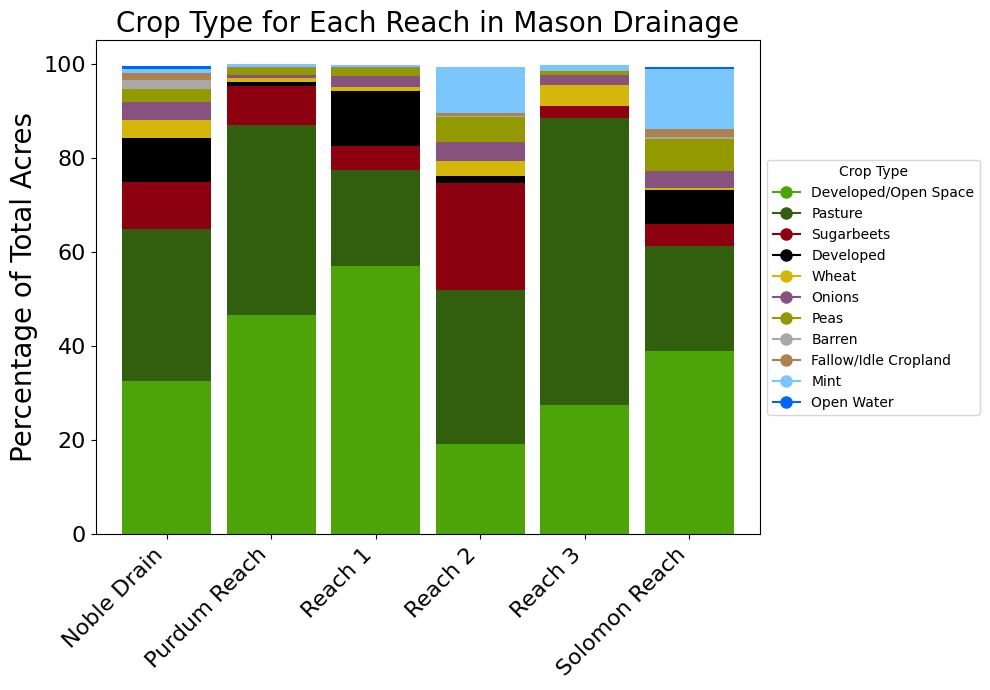

In [38]:
# ------------------------ #
# Figure: Major crop types
# ------------------------ #


df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/2023_cdl_reach.csv')

# Calculate total acres per reach to calculate percentages
df['Total_Acres'] = df.groupby('Reach')['Acres'].transform('sum')
df['Percentage'] = (df['Acres'] / df['Total_Acres']) * 100  # Calculate percentage for each crop type per reach

# Pivot the data to prepare for plotting
pivot_df = df.pivot_table(index='Reach', columns='Crop', values='Percentage', aggfunc='sum', fill_value=0)

# Sort crops within each reach by percentage in descending order
sorted_columns = pivot_df.apply(lambda row: row.sort_values(ascending=False).index, axis=1)
sorted_pivot_df = pivot_df[sorted_columns.iloc[0]]  # Reorder columns for stacked bar plot

# Define the color palette
crop_palette = {
    "Corn": "xkcd:powder blue",
    "Dry Beans": "xkcd:light brown",
    "Greens": "xkcd:yellow green",
    "Mint": "#7CC6FE",
    "Fallow/Idle Cropland": "xkcd:light brown",
    "Wheat": "xkcd:dark yellow",
    "Sugar Crop": "xkcd:greyish",
    "Alfalfa": "xkcd:amber",
    "Onions": "#88527F",
    "Shrubland": "#D33E43",
    "Herb": "xkcd:washed out green",
    "Peas": "xkcd:pea soup",
    "Oats": "xkcd:rose",
    "Other": "xkcd:light grey",
    "Herbs": "xkcd:dark teal",
    "Pasture": "#325F0E",
    "Turnips": "xkcd:bright purple",
    "Developed": "xkcd:black",
    "Developed/Open Space": "xkcd:lawn green",
    "Sugarbeets": "xkcd:crimson",
    "Carrots": "xkcd:red orange",
    "Potatoes": "xkcd:dark brown",
    "Open Water": "xkcd:bright blue",
    "Double Crop": "xkcd:black",
    "Vegetables/Fruit": "#846075",
    "Barren": "#A8A8A8",
}

# Filter the color palette to include only present crops
present_crops = sorted_pivot_df.columns[sorted_pivot_df.sum() > 0.5]
filtered_palette = {crop: crop_palette.get(crop, "grey") for crop in present_crops}

# Match colors in the order of filtered crops
colors = [filtered_palette[crop] for crop in present_crops]

# Create the plot with only relevant crops
fig, ax = plt.subplots(figsize=(10, 7))
sorted_pivot_df[present_crops].plot(kind='bar', stacked=True, ax=ax, width=0.85, color=colors)

# Move the legend outside the plot
patches = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) for label, color in filtered_palette.items()]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Crop Type")

# Add labels and title
plt.ylabel('Percentage of Total Acres', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16, rotation=45, ha='right')  # Tilts the x-axis labels at 45 degrees
plt.title('Crop Type for Each Reach in Mason Drainage', fontsize=20)

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/Figures/2023_cdl_reach.png', dpi=300)
plt.close()

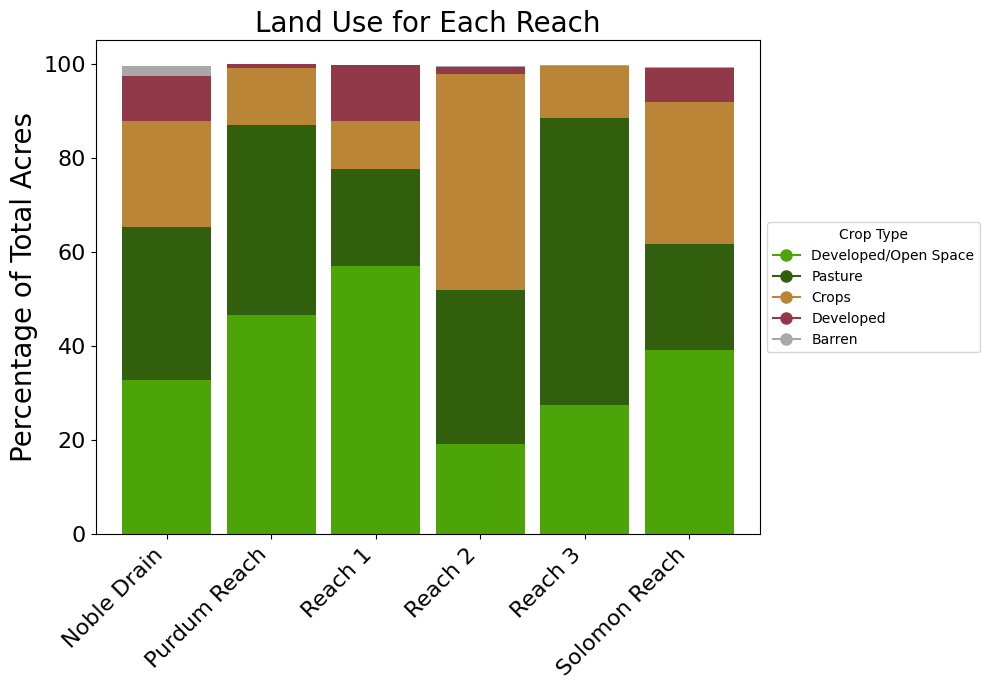

In [43]:
# ------------------------ #
# Figure: Simplified land use (%)
# ------------------------ #

df = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/2023_cdl_reach.csv')

#combine crops into new category "Crops"
crops_to_combine = [
    "Corn", "Dry Beans", "Greens", "Mint", "Fallow/Idle Cropland",
    "Sugar Crop", "Onions", "Herb", "Peas", "Herbs", "Turnips",
    "Sugarbeets", "Carrots", "Potatoes", "Double Crop", "Vegetables/Fruit", "Wheat"
]

# Replace the specified crop types with "Crops"
df['Crop'] = df['Crop'].apply(lambda x: "Crops" if x in crops_to_combine else x)

# Remove "Open Water" from the dataset
df = df[df['Crop'] != "Open Water"]

# Calculate total acres per reach to calculate percentages
df['Total_Acres'] = df.groupby('Reach')['Acres'].transform('sum')
df['Percentage'] = (df['Acres'] / df['Total_Acres']) * 100  # Calculate percentage for each crop type per reach

# Pivot the data to prepare for plotting
pivot_df = df.pivot_table(index='Reach', columns='Crop', values='Percentage', aggfunc='sum', fill_value=0)

# Sort crops within each reach by percentage in descending order
sorted_columns = pivot_df.apply(lambda row: row.sort_values(ascending=False).index, axis=1)
sorted_pivot_df = pivot_df[sorted_columns.iloc[0]]  # Reorder columns for stacked bar plot

# Define the color palette (assign a single color to "Crops")
crop_palette = {
    "Crops": "#BA8536",  # Unified "Crops" category
    "Shrubland": "#D33E43",
    "Pasture": "#325F0E",
    "Developed": "#913948",
    "Developed/Open Space": "xkcd:lawn green",
    "Barren": "#A8A8A8",
    "Other": "xkcd:light grey"
}

# Filter the color palette to include only present crops
present_crops = sorted_pivot_df.columns[sorted_pivot_df.sum() > 0.5]
filtered_palette = {crop: crop_palette.get(crop, "grey") for crop in present_crops}

# Match colors in the order of filtered crops
colors = [filtered_palette[crop] for crop in present_crops]

# Create the plot with only relevant crops
fig, ax = plt.subplots(figsize=(10, 7))
sorted_pivot_df[present_crops].plot(kind='bar', stacked=True, ax=ax, width=0.85, color=colors)

# Move the legend outside the plot
patches = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) for label, color in filtered_palette.items()]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Crop Type")

# Add labels and title
plt.ylabel('Percentage of Total Acres', fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16, rotation=45, ha='right')  # Tilts the x-axis labels at 45 degrees
plt.title('Land Use for Each Reach', fontsize=20)

plt.tight_layout()
plt.show()
plt.savefig('/content/drive/MyDrive/Data/Mason Water Budget/data_output/land_use/Figures/2023_landuse_reach.png', dpi=300)
plt.close()